In [59]:
import http.client, urllib.request, urllib.parse, urllib.error, base64
import requests
import json
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ntpath
import pandas as pd

In [60]:
subscription_key = "##########"
base_url = "######"

In [61]:
def display_trained_faces():
    %matplotlib inline
    images = {}
    img = []
    for img_path in glob.glob('Faces/Trained/*.jpg'):
        data = mpimg.imread(img_path)
        key = ntpath.basename(img_path).replace('.jpg','')
        images[key] = data
        img.append(data)

    plt.figure(figsize=(20,10))
    columns = 5
    i = 0
    for key, image in images.items():
        plt.subplot(len(img) / columns + 1, columns, i + 1)
        plt.title(key)
        plt.imshow(image)
        i = i + 1

In [62]:
def request(method, url, data=None, json=None, headers=None, params=None):
    if not url.startswith('https://'):
        url = base_url + url

    headers = headers or {}
    if 'Content-Type' not in headers:
        headers['Content-Type'] = 'application/json'
    headers['Ocp-Apim-Subscription-Key'] = subscription_key

    response = requests.request(
        method,
        url,
        params=params,
        data=data,
        json=json,
        headers=headers)

    result = None
    if response.status_code not in (200, 202):
        try:
            error_msg = response.json()['error']
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))

    if response.text:
        result = response.json()
    else:
        result = {}

    return result

In [63]:
def create_person_group(person_group_id, name=None, user_data=None):
    name = name or person_group_id
    url = 'persongroups/{}'.format(person_group_id)
    json = {
        'name': name,
        'userData': user_data,
    }
    return request('PUT', url, json=json)

In [64]:
create_person_group('face_demo')

{}

In [50]:
def create_person_in_person_group(person_group_id, name, user_data=None):
    url = 'persongroups/{}/persons'.format(person_group_id)
    json = {
        'name': name,
        'userData': user_data,
    }

    return request('POST', url, json=json)

In [65]:
print(create_person_in_person_group('face_demo', 'tony'))
print(create_person_in_person_group('face_demo', 'steve'))

{'personId': '7b21f2be-30df-47b2-8c8c-8c848377034f'}
{'personId': '0e91c096-0379-4666-bfd2-9a7f0ad2c25a'}


In [72]:
print(create_person_in_person_group('face_demo', 'billgates'))

{'personId': 'cdf3ab0f-9e8d-412f-9866-651b04a089d9'}


In [51]:
def lists_persons(person_group_id, start=None, top=None):
    url = 'persongroups/{}/persons'.format(person_group_id)
    params = {
        'start': start,
        'top': top,
    }
    return request('GET', url, params=params)

In [52]:
def add_face(image, person_group_id, person_id, user_data=None, target_face=None):
    
    url = 'persongroups/{}/persons/{}/persistedFaces'.format(
        person_group_id, person_id)
    headers = {'Content-Type': 'application/octet-stream'}
    data = open(image, 'rb').read()
    params = {
        'userData': user_data,
        'targetFace': target_face,
    }

    return request(
        'POST', url, headers=headers, params=params, json=json, data=data)

In [67]:
image = r"C:\Users\Balajisri\Documents\Deep Learning\Azure Face\Faces\Trained\Tony.jpg"
person_group_id = 'face_demo'
person_id = '7b21f2be-30df-47b2-8c8c-8c848377034f'
add_face(image, person_group_id, person_id)

{'persistedFaceId': 'eb2facec-625c-4871-9e2b-b3228ec69be3'}

In [68]:
image = r"C:\Users\Balajisri\Documents\Deep Learning\Azure Face\Faces\Trained\Steve.jpg"
person_group_id = 'face_demo'
person_id = '0e91c096-0379-4666-bfd2-9a7f0ad2c25a'
add_face(image, person_group_id, person_id)

{'persistedFaceId': 'ab8a7a51-3910-45b8-8311-bf13604b3048'}

In [73]:
image = r"C:\Users\Balajisri\Documents\Deep Learning\Azure Face\Faces\Trained\billgates.jpg"
person_group_id = 'face_demo'
person_id = 'cdf3ab0f-9e8d-412f-9866-651b04a089d9'
add_face(image, person_group_id, person_id)

{'persistedFaceId': '08f89e30-2714-4b09-b23e-4ce2213a162f'}

In [74]:
lists_persons('face_demo')

[{'personId': '0e91c096-0379-4666-bfd2-9a7f0ad2c25a',
  'persistedFaceIds': ['ab8a7a51-3910-45b8-8311-bf13604b3048'],
  'name': 'steve',
  'userData': None},
 {'personId': '7b21f2be-30df-47b2-8c8c-8c848377034f',
  'persistedFaceIds': ['eb2facec-625c-4871-9e2b-b3228ec69be3'],
  'name': 'tony',
  'userData': None},
 {'personId': 'cdf3ab0f-9e8d-412f-9866-651b04a089d9',
  'persistedFaceIds': ['08f89e30-2714-4b09-b23e-4ce2213a162f'],
  'name': 'billgates',
  'userData': None}]

In [53]:
def train(person_group_id):
    url = 'persongroups/{}/train'.format(person_group_id)
    return request('POST', url)

In [75]:
train('face_demo')

{}

In [76]:
def get_status(person_group_id):
    url = 'persongroups/{}/training'.format(person_group_id)
    return request('GET', url)

In [77]:
get_status('face_demo')

{'status': 'succeeded',
 'createdDateTime': '2019-11-26T17:56:56.7731865Z',
 'lastActionDateTime': '2019-11-26T17:56:57.0460481Z',
 'message': None}

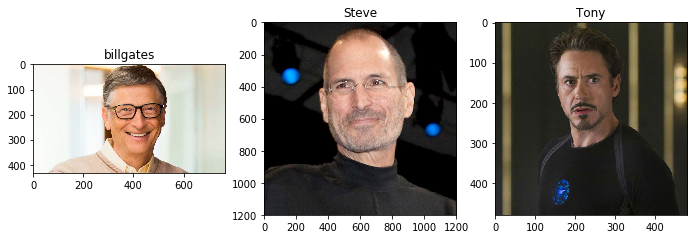

In [78]:
display_trained_faces()

In [55]:
def detect(image, face_id=True, landmarks=False, attributes=''):
    url = 'detect'
    headers = {'Content-Type': 'application/octet-stream'}
    data = open(image, 'rb').read()
    params = {
        'returnFaceId': face_id and 'true' or 'false',
        'returnFaceLandmarks': landmarks and 'true' or 'false',
        'returnFaceAttributes': attributes,
    }

    return request(
        'POST', url, headers=headers, params=params, json=json, data=data)

In [56]:
def identify(face_ids,
             person_group_id=None,
             large_person_group_id=None,
             max_candidates_return=1,
             threshold=None):
    url = 'identify'
    json = {
        'personGroupId': person_group_id,
        'largePersonGroupId': large_person_group_id,
        'faceIds': face_ids,
        'maxNumOfCandidatesReturned': max_candidates_return,
        'confidenceThreshold': threshold,
    }

    return request('POST', url, json=json)

In [106]:
def scan_face(path):
    detect_response = detect(image)
    #print(detect_response)
    
    persons = lists_persons('face_demo')
    identify_response = identify([detect_response[0]['faceId']], 'face_demo')
    identified_person = identify_response[0]['candidates'][0]['personId']
    identified_confidence = identify_response[0]['candidates'][0]['confidence']
    
    plt.figure(figsize=(10,5))
    data = mpimg.imread(image)
    plt.imshow(data)

    person = next(person for person in persons if person["personId"] == identified_person)
    print('Person Identified - ',person['name'])
    print('Confidence - ', identified_confidence)

Person Identified -  tony
Confidence -  0.64149


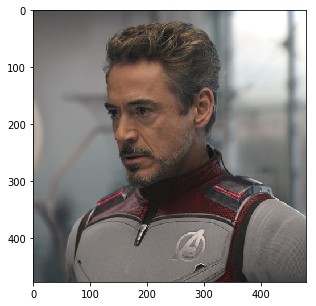

In [111]:
image = r"C:\Users\Balajisri\Documents\Deep Learning\Azure Face\Faces\Test\tony_test.jpg"
scan_face(image)